### Import

In [128]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import *
from functools import partial
import multiprocessing

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn.colors.xkcd_rgb as c
import cmaps

In [2]:
import vvmtoolsV2
import importlib
importlib.reload(vvmtoolsV2)

<module 'vvmtoolsV2' from '/data/mlcloud/ch995334/hw/vvmtoolsV2.py'>

## HW8.1

### Output format-controlled .nc files

#### Different landtypes
OU, GU, PU, EU, 
OG, OP, OE, 
PG, GE,
PE

In [60]:
mytools_ou_s1 = vvmtoolsV2.VVMtools(f"/data/aries/VVM/DATA/pbl_ou")
mytools_ou_s2 = vvmtoolsV2.VVMtools(f"/data/C.shaoyu/VVM/DATA/pbl_ou_11dth_6tr")

In [61]:
mytools_gu_s1 = vvmtoolsV2.VVMtools(f"/data/C.shaoyu/VVM/DATA/pbl_gu_8dth_6tr")
mytools_gu_s2 = vvmtoolsV2.VVMtools(f"/data/C.shaoyu/VVM/DATA/pbl_gu_11dth_6tr")

In [62]:
mytools_pu_s1 = vvmtoolsV2.VVMtools(f"/data/yhc2080/VVM/DATA/pbl_PU_s1")
mytools_pu_s2 = vvmtoolsV2.VVMtools(f"/data/yhc2080/VVM/DATA/pbl_PU_s2")

In [63]:
mytools_eu_s1 = vvmtoolsV2.VVMtools(f"/data/C.shaoyu/VVM/DATA/pbl_eu_8dth_6tr")
mytools_eu_s2 = vvmtoolsV2.VVMtools(f"/data/C.shaoyu/VVM/DATA/pbl_eu_11dth_6tr")

In [64]:
mytools_og_s1 = vvmtoolsV2.VVMtools(f"/data/mlcloud/Aaron/VVM/DATA/OceanGrass_S1_landmid_new")
mytools_og_s2 = vvmtoolsV2.VVMtools(f"/data/mlcloud/Aaron/VVM/DATA/OceanGrass_S2_landmid_newnew")

In [65]:
mytools_op_s1 = vvmtoolsV2.VVMtools(f"/data/C.shaoyu/VVM/DATA/pbl_op_8dth_6tr")
mytools_op_s2 = vvmtoolsV2.VVMtools(f"/data/C.shaoyu/VVM/DATA/pbl_op_11dth_6tr")

In [3]:
mytools_oe_s1 = vvmtoolsV2.VVMtools(f"/data/mlcloud/ch995334/VVM/DATA/pbl_mod_wfire_coastal_s1/")
mytools_oe_s2 = vvmtoolsV2.VVMtools(f"/data/mlcloud/ch995334/VVM/DATA/pbl_mod_wfire_coastal_s2/")

In [66]:
mytools_pg_s1 = vvmtoolsV2.VVMtools(f"/home/eason6588/CD/VVM/DATA/PG_s1")
mytools_pg_s2 = vvmtoolsV2.VVMtools(f"/home/eason6588/CD/VVM/DATA/PG_s2")

In [67]:
mytools_ge_s1 = vvmtoolsV2.VVMtools(f"/data/mlcloud/r13229012/VVM/DATA/pbl_EG_S1")
mytools_ge_s2 = vvmtoolsV2.VVMtools(f"/data/mlcloud/r13229012/VVM/DATA/pbl_EG_S2")

In [68]:
mytools_pe_s1 = vvmtoolsV2.VVMtools(f"/data/mlcloud/r13229010/VVM/DATA/case_HW8b")
mytools_pe_s2 = vvmtoolsV2.VVMtools(f"/data/mlcloud/r13229010/VVM/DATA/case_HW8a")

#### Function to make .nc files

In [7]:
import vvmtools  # version 1.1.0
def Output_to_nc(lu:str, sounding:str):
    mytools_case = eval(f"mytools_{lu}_{sounding}")
    # Get domain-averaged theta, enstrophy, tke, w'th' (a-grid)
    domain_range = (None, None, None, None, None, None)
    th_agrid     = mytools_case.get_var_parallel('th', np.arange(721))
    th_mean      = th_agrid.mean(axis=(-2, -1))
    enst_agrid   = mytools_case.func_time_parallel(func=mytools_case.cal_enstrophy,
                                                   time_steps=np.arange(721),
                                                   func_config={'domain_range':domain_range}, cores=10)
    enst_format  = np.concatenate((np.zeros((enst_agrid.shape[0], 1)), enst_agrid), axis=1)
    tke_agrid    = mytools_case.func_time_parallel(func=mytools_case.cal_TKE,
                                                   time_steps=np.arange(721),
                                                   func_config={'domain_range':domain_range}, cores=10)
    tke_format   = np.concatenate((np.zeros((tke_agrid.shape[0], 1)), tke_agrid), axis=1)
    wth_agrid    = mytools_case.func_time_parallel(func=mytools_case.cal_turb_flux,
                                                   time_steps=np.arange(721),
                                                   func_config={'domain_range':domain_range,
                                                                'wind_var':'w',
                                                                'prop_var':'th'}, cores=10)
    wth_mean     = wth_agrid.mean(axis=(-2, -1))
    wth_format   = np.concatenate((np.zeros((wth_mean.shape[0], 1)), wth_mean), axis=1)
    
    # Create .nc file
    nz, nt = 50, 721
    dim_data_dict = {
        "time": (np.arange(nt)*np.timedelta64(2,'m')+np.datetime64('2024-01-01 05:00:00')).astype('datetime64[s]'),
        "height": np.arange(nz)*0.04
    }
    data_dict = {
        "th": th_mean,
        "enstrophy": enst_format,
        "tke": tke_format,
        "wth": wth_format
    }
    var_dims_dict = {
        "th": ("time", "height"),
        "enstrophy": ("time", "height"),
        "tke": ("time", "height"),
        "wth": ("time", "height")
    }
    attributes = {
        "th": {"units": "K", "description": "x-y mean potential temperature (t,z)"},
        "enstrophy": {"units": "1/(s^2)", "description": "x-y mean enstrophy (t,z)"},
        "tke": {"units": "(m^2)/(s^2)", "description": "x-y mean turbulent kinetic energy (t,z)"},
        "wth": {"units": "(m/s)*(K)", "description": "x-y mean turbulent flux (t,z)"},
        "time": {"description": "Local Time"},  # Removed 'units' for time
        "height": {"units": "m", "description": "Height in grid center"},
    }

    # Example of creating a NetCDF file with flexible dimensions
    vvmtools.analyze.create_nc_output(f"./Data/lu_profs/{lu}_{sounding}.nc", dim_data_dict, data_dict, var_dims_dict, attributes)

In [69]:
for landtype in ['OU', 'GU', 'PU', 'EU', 'OG', 'OP', 'PG', 'GE', 'PE']:
    for sounding in ['s1', 's2']:
        Output_to_nc(lu=landtype.lower(), sounding=sounding)

NetCDF file './Data/lu_profs/ou_s1.nc' created successfully.
NetCDF file './Data/lu_profs/ou_s2.nc' created successfully.
NetCDF file './Data/lu_profs/gu_s1.nc' created successfully.
NetCDF file './Data/lu_profs/gu_s2.nc' created successfully.
NetCDF file './Data/lu_profs/pu_s1.nc' created successfully.
NetCDF file './Data/lu_profs/pu_s2.nc' created successfully.
NetCDF file './Data/lu_profs/eu_s1.nc' created successfully.
NetCDF file './Data/lu_profs/eu_s2.nc' created successfully.
NetCDF file './Data/lu_profs/og_s1.nc' created successfully.
NetCDF file './Data/lu_profs/og_s2.nc' created successfully.
NetCDF file './Data/lu_profs/op_s1.nc' created successfully.
NetCDF file './Data/lu_profs/op_s2.nc' created successfully.
NetCDF file './Data/lu_profs/pg_s1.nc' created successfully.
NetCDF file './Data/lu_profs/pg_s2.nc' created successfully.
NetCDF file './Data/lu_profs/ge_s1.nc' created successfully.
NetCDF file './Data/lu_profs/ge_s2.nc' created successfully.
NetCDF file './Data/lu_p

## Test

In [9]:
ds_oes1 = xr.open_dataset('./Data/lu_profs/oe_s1.nc')

In [15]:
ds_oes2 = xr.open_dataset('./Data/lu_profs/oe_s2.nc')

In [25]:
ds_oes1.time

<xarray.DataArray 'time' (time: 721)>
array(['2024-01-01T05:00:00.000000000', '2024-01-01T05:02:00.000000000',
       '2024-01-01T05:04:00.000000000', ..., '2024-01-02T04:56:00.000000000',
       '2024-01-02T04:58:00.000000000', '2024-01-02T05:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2024-01-01T05:00:00 ... 2024-01-02T05:00:00
Attributes:
    description:  Local Time

In [147]:
def Plot_lu_profiles(lu:str, savefig:bool=False):
    import matplotlib.cm as cm
    # Data
    ds_lus1 = xr.open_dataset(f'./Data/lu_profs/{lu}_s1.nc')
    # Plot
    fig, ax = plt.subplots(2, 3, sharey=True, figsize=(12, 12), gridspec_kw={'wspace':0.1})
    fig.delaxes(ax[0, 2])
    n = 25
    cmap   = cmaps.WhiteBlueGreenYellowRed[10:]
    ccolors= cmap(np.linspace(0,1,n))
    for i in range(int(721/30)):
        y = ds_lus1.height
        ax[0, 0].plot(ds_lus1.th.isel(time=int(i*30)), y, color=ccolors[i], linewidth=3)
        ax[0, 1].plot(ds_lus1.th.isel(time=int(i*30+1))-ds_lus1.th.isel(time=int(i*30)), y, color=ccolors[i], linewidth=3)
        ax[1, 0].plot(ds_lus1.wth.isel(time=int(i*30)), y, color=ccolors[i], linewidth=3)
        ax[1, 1].plot(ds_lus1.enstrophy.isel(time=int(i*30))*1e5, y, color=ccolors[i], linewidth=3)
        ax[1, 2].plot(ds_lus1.tke.isel(time=int(i*30)), y, color=ccolors[i], linewidth=3)
    ## Grid lines
    for axe in ax.flatten():
        axe.grid(linestyle=':', linewidth=0.5, color='grey')
    ## Colorbar
    bounds = np.arange(721//30)
    norm   = colors.BoundaryNorm(bounds, cmap.N)
    cax  = fig.add_axes([ax[0, 1].get_position().x1+0.01, ax[0, 1].get_position().y0, 
                         0.015, ax[0, 1].get_position().height])
    cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), 
                        cax=cax, orientation='vertical')
    cbar.set_ticks(ticks=((bounds[:-1]+bounds[1:])/2)[::2], 
                   labels=[f'{(datetime(2024, 1, 1, 5)+timedelta(seconds=time*120)).strftime("%H:%M")}' for time in range(0, 721-60, 30)][::2])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('(LST)', fontsize=14)
    ## Fig range
    ax[0, 0].set_xlim([293, 308])
    ax[0, 1].set_xlim([-0.05, 0.05])
    ax[1, 0].set_xlim([-0.02, 0.04])
    ax[1, 1].set_xlim([-0.5, 15])
    ax[1, 2].set_xlim([-0.05, 2])
    ax[0, 0].set_ylim([0, 2])
    ## Fig info.
    ax[0, 0].set_title(r'$\theta$', fontsize=14)
    ax[0, 1].set_title(r'$\theta$(t+1) - $\theta$(t)', fontsize=14)
    ax[1, 0].set_title(r"$\overline{w'th'}$", fontsize=14)
    ax[1, 1].set_title(r'Enstrophy (1$0^{-5}$)', fontsize=14)
    ax[1, 2].set_title('TKE', fontsize=14)
    fig.suptitle(x=0.5, y=0.93, t=f"{lu.upper()}", fontweight='bold', fontsize=18)
    if savefig:
        plt.savefig(f"./Figure/Final/lu_profs/{lu}.png", facecolor='w', bbox_inches='tight', dpi=400)
    else:
        plt.show()

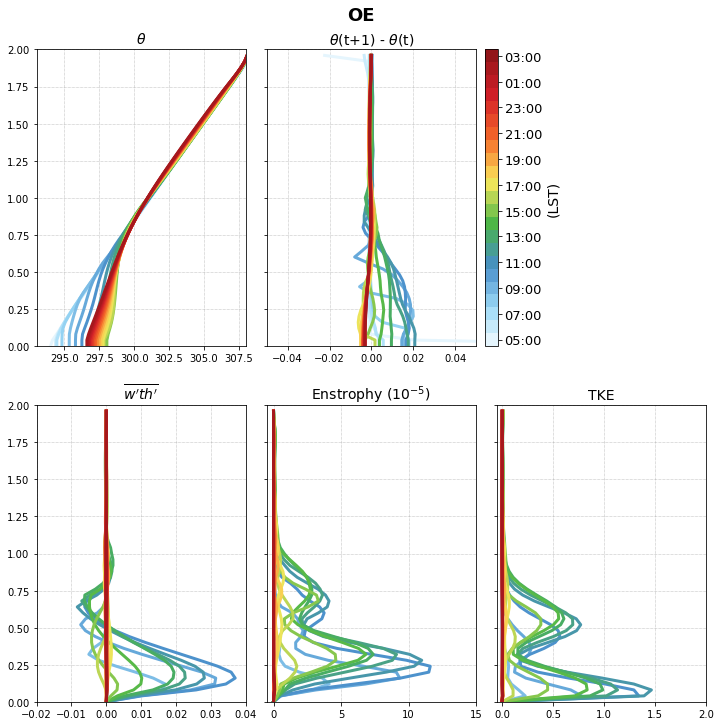

In [148]:
Plot_lu_profiles('oe')

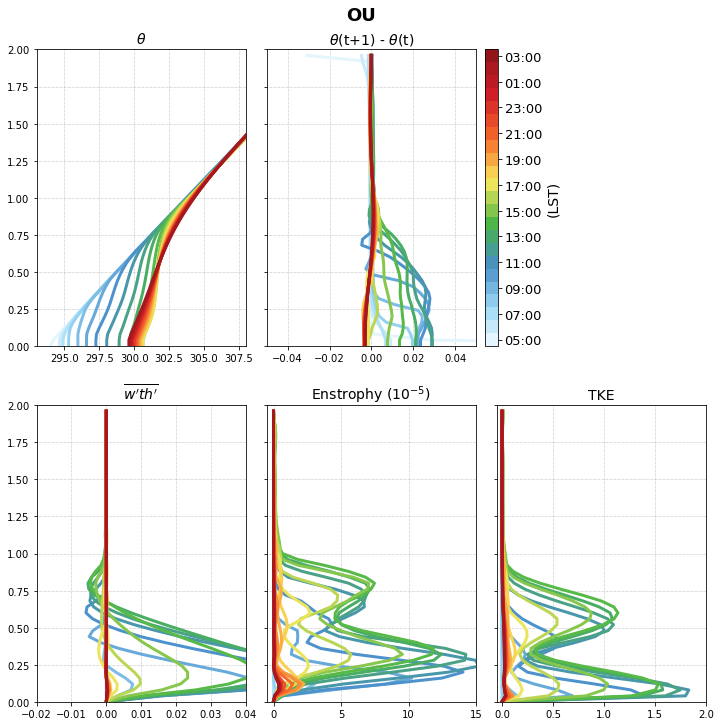

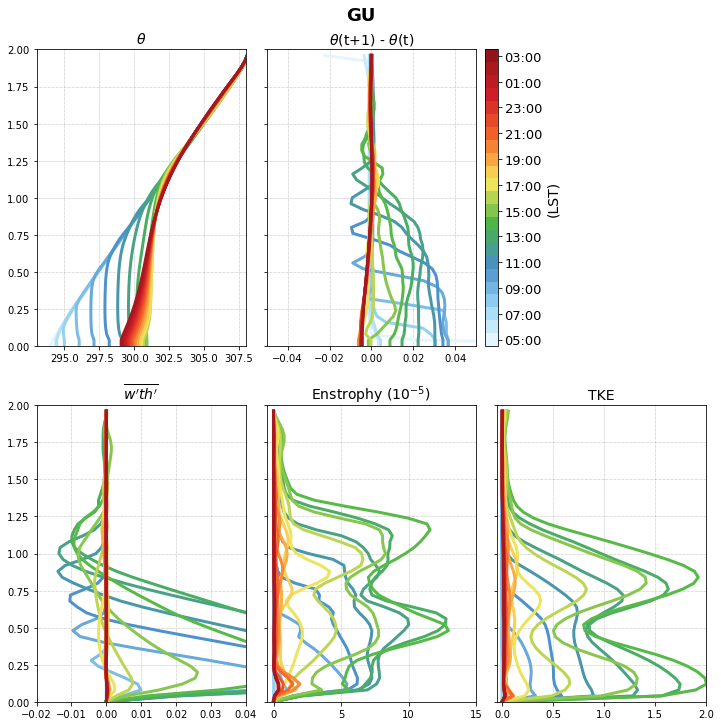

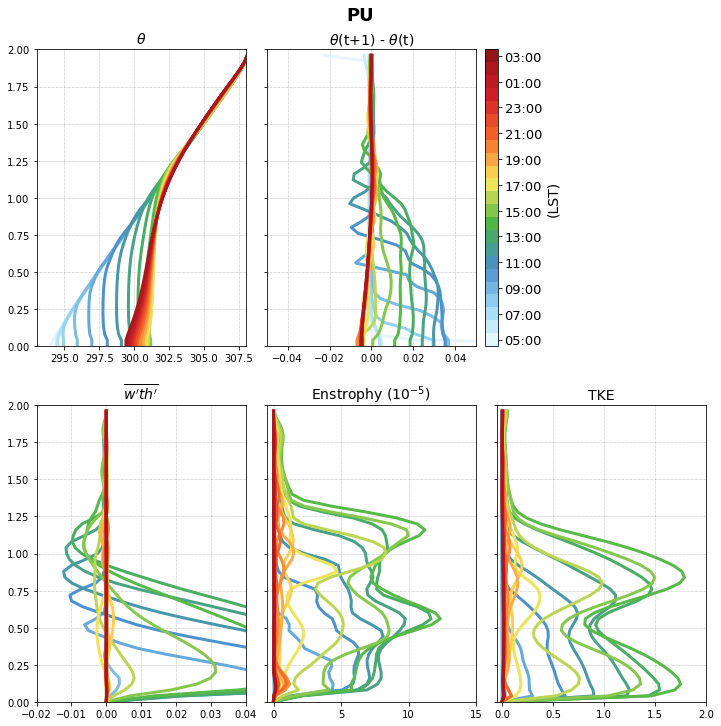

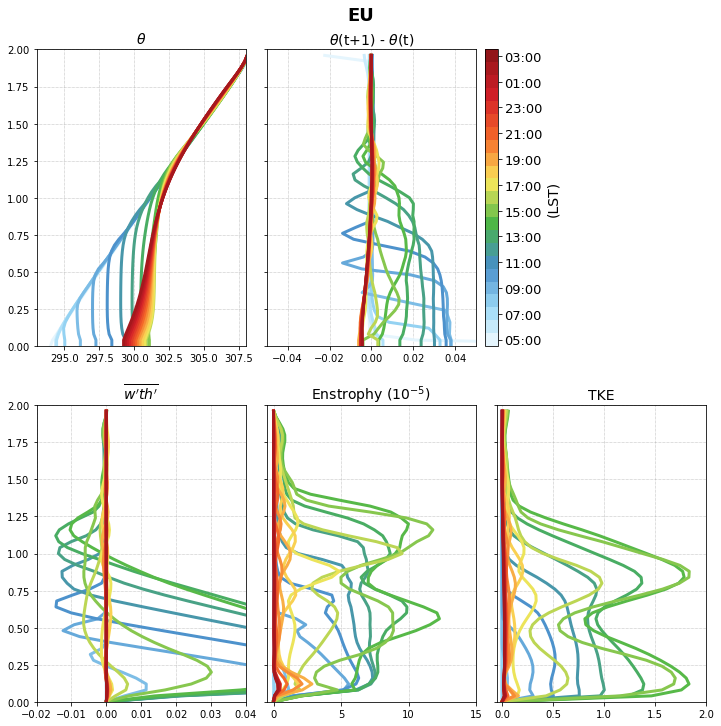

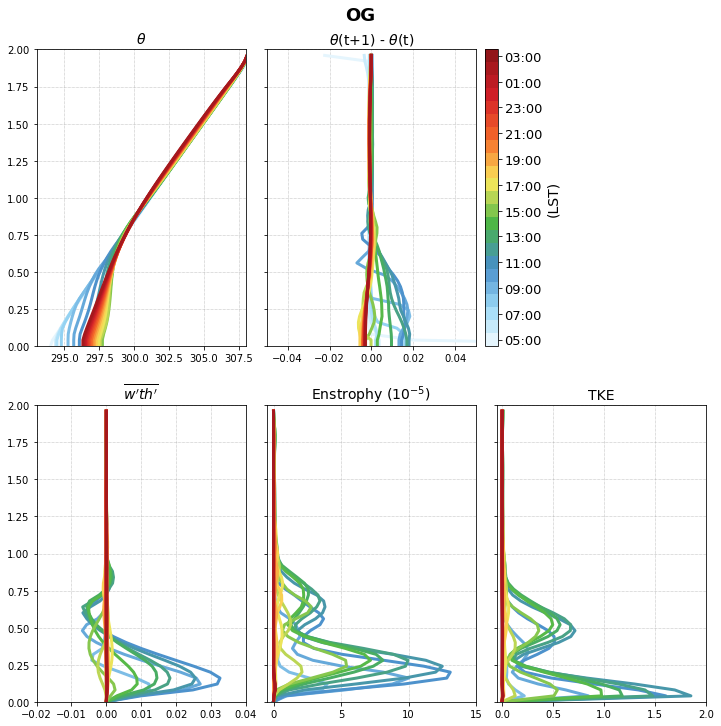

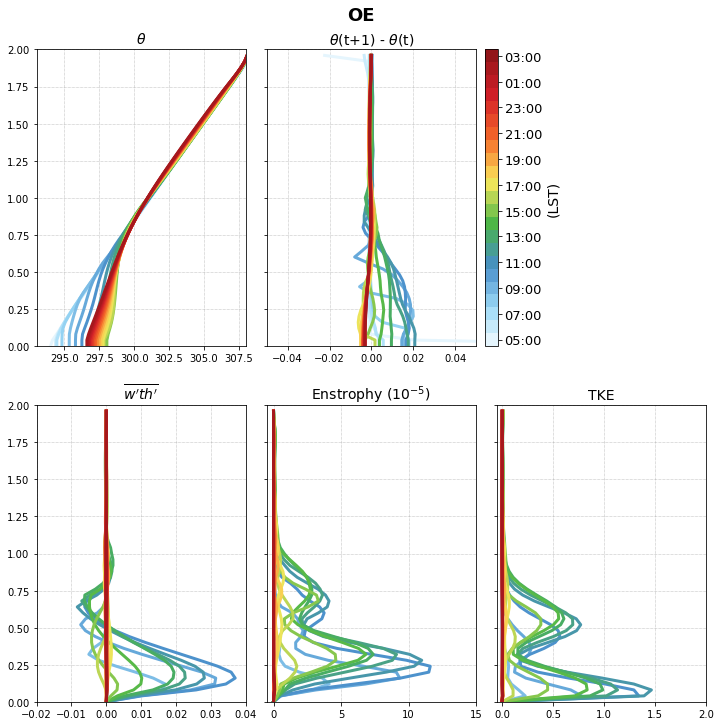

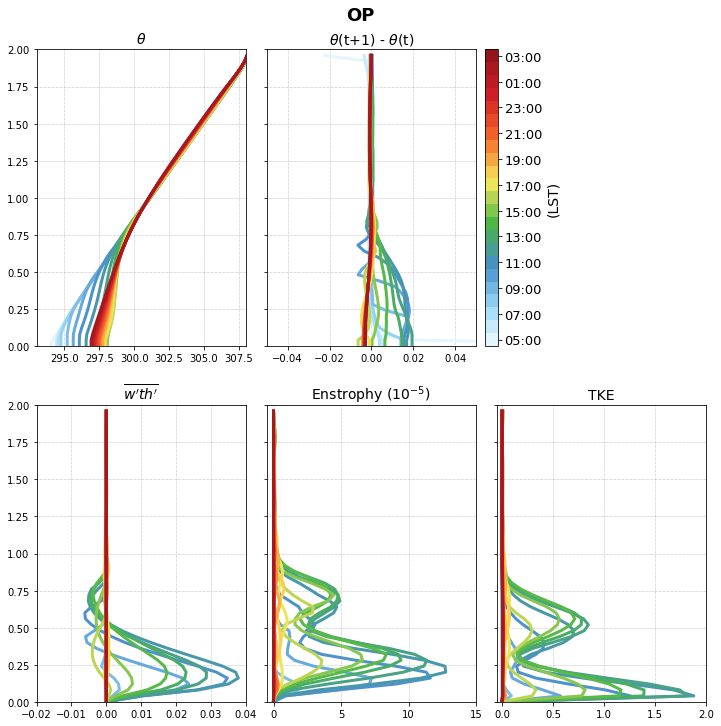

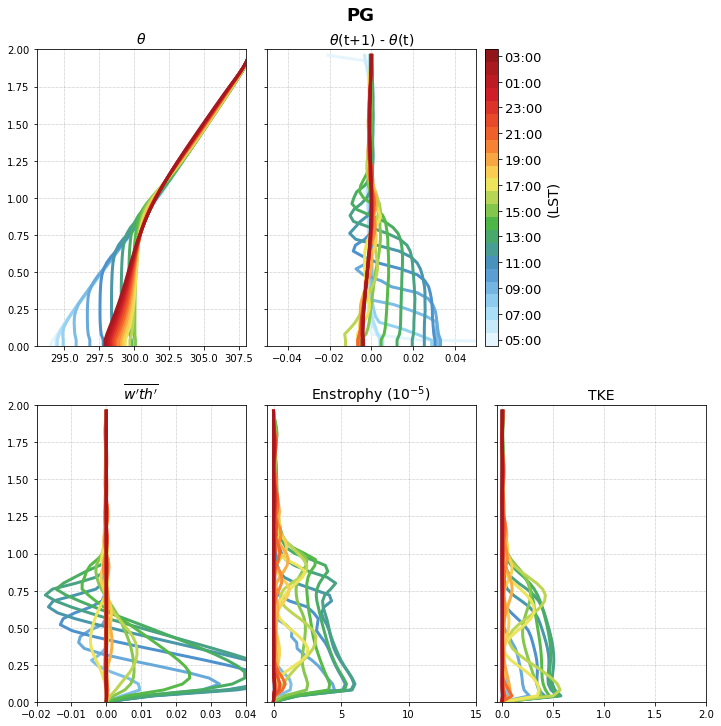

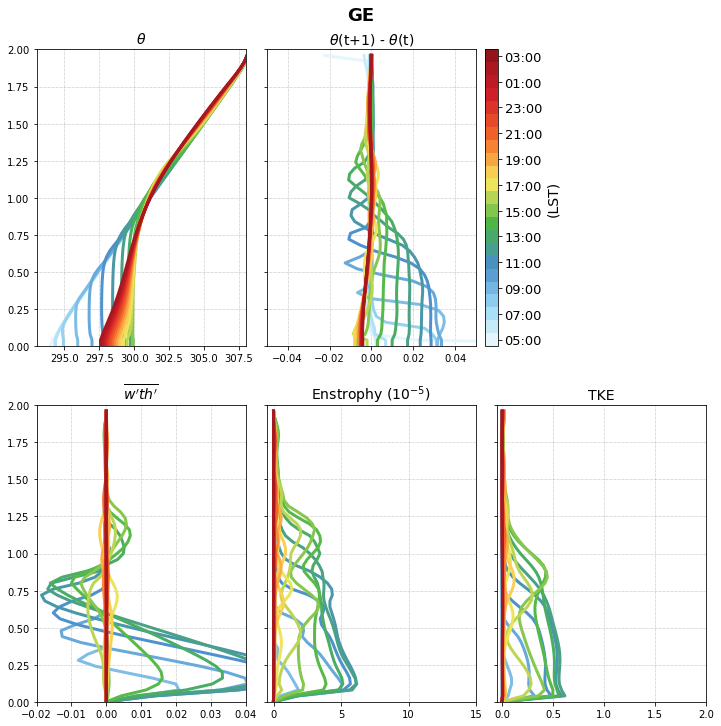

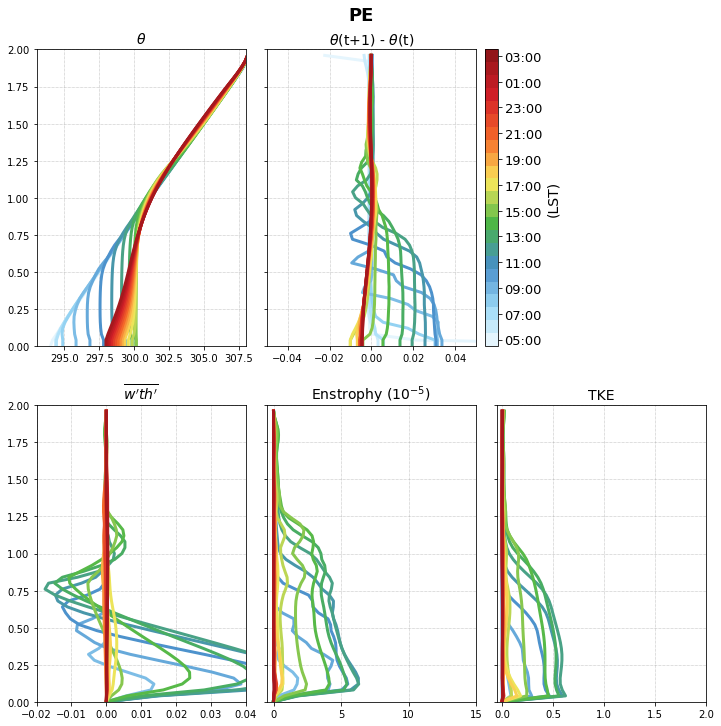

In [149]:
for landtype in ['OU', 'GU', 'PU', 'EU', 'OG', 'OE', 'OP', 'PG', 'GE', 'PE']:
    Plot_lu_profiles(lu=landtype.lower(), savefig=True)

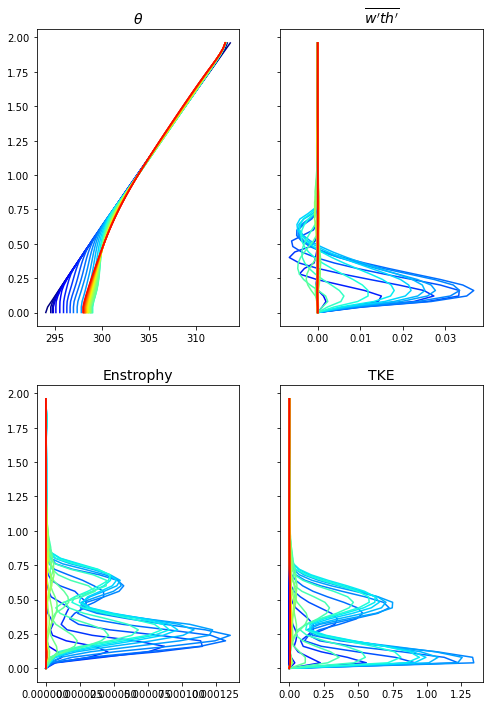

In [38]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(8, 12))
n = 40
colors = plt.cm.jet(np.linspace(0,1,40))
for i in range(int(721/20)):
    y = ds_oes1.height
    ax[0, 0].plot(ds_oes2.th.isel(time=int(i*20)), y, color=colors[i])
    ax[0, 1].plot(ds_oes2.wth.isel(time=int(i*20)), y, color=colors[i])
    ax[1, 0].plot(ds_oes2.enstrophy.isel(time=int(i*20)), y, color=colors[i])
    ax[1, 1].plot(ds_oes2.tke.isel(time=int(i*20)), y, color=colors[i])
ax[0, 0].set_title(r'$\theta$', fontsize=14)
ax[0, 1].set_title(r"$\overline{w'th'}$", fontsize=14)
ax[1, 0].set_title('Enstrophy', fontsize=14)
ax[1, 1].set_title('TKE', fontsize=14)
plt.show()

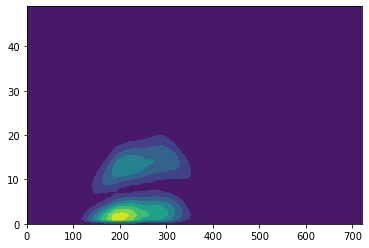

In [39]:
plt.contourf(ds_oes1.tke.T)

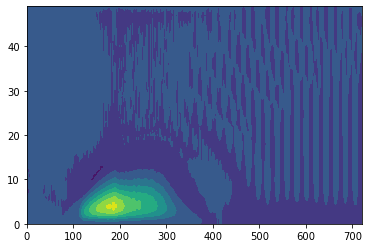

In [40]:
plt.contourf(ds_oes2.wth.T)

In [5]:
vvmtools_hw9 = vvmtoolsV2.VVMtools(f"/data/mlcloud/ch995334/VVM/DATA/pbl_hw9_s1/")

In [27]:
tr_dict = {}
for i in range(6):
    tr_dict[f"tr{i+1:02d}"] = vvmtools_hw9.get_var(f"tr{i+1:02d}", time=1)

In [30]:
tr_dict['tr01'].max()

<xarray.DataArray 'tr01' ()>
array(115.18248749)

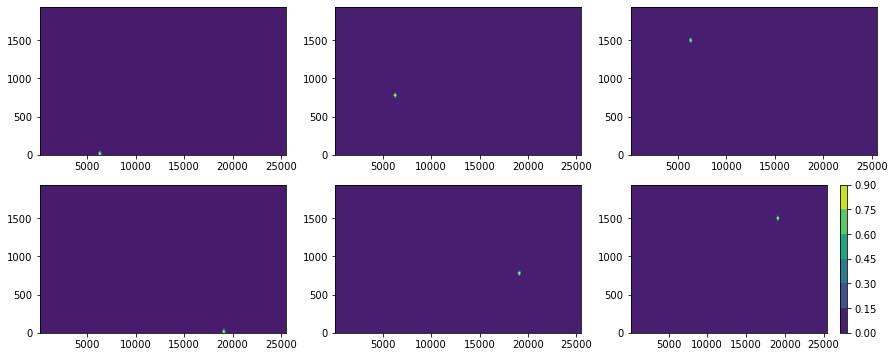

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
for i, ax_sub in enumerate(ax.flatten()):
    im   = ax_sub.contourf(vvmtools_hw9.DIM['xc'], vvmtools_hw9.DIM['zc'], tr_dict[f"tr{i+1:02d}"].isel(time=0).mean(dim=['lat']))
    # ax_sub.set_yticks(vvmtools_hw9.DIM['zc'])
fig.colorbar(im)

In [52]:
time_chem = 1
no1 = vvmtools_hw9.get_var("NO", time=time_chem)
no2 = vvmtools_hw9.get_var("NO2", time=time_chem)
trchem = vvmtools_hw9.get_var("INERT", time_chem)

<xarray.DataArray 'NO' ()>
array(1.33622801)
<xarray.DataArray 'NO2' ()>
array(21.06964874)
<xarray.DataArray 'INERT' ()>
array(2.31141353)


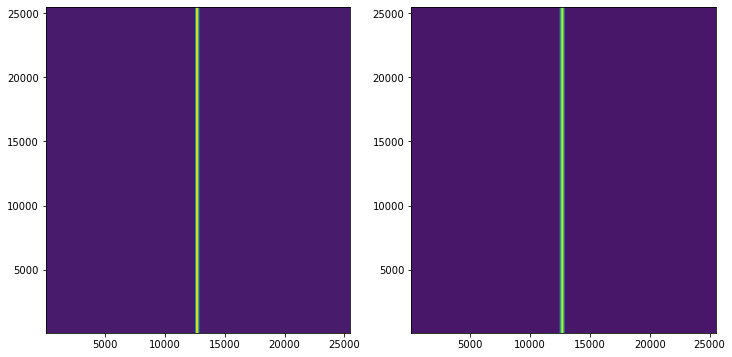

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for i, ax_sub in enumerate(ax.flatten()):
    im   = ax_sub.contourf(vvmtools_hw9.DIM['xc'], vvmtools_hw9.DIM['yc'], eval(f"no{i+1:d}").isel(time=0, lev=0))
print(no1.mean(dim='lat').max())
print(no2.mean(dim='lat').max())
print(trchem.mean(dim='lat').max())

In [118]:
example081 = np.load('./Data/hw081.npy', allow_pickle=True)

In [123]:
example081[0, ..., 0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.29584166e-05,  4.07275220e-05, ...,
         1.95968508e-09,  1.59347835e-09,  6.91580460e-10],
       [ 0.00000000e+00,  1.64461708e-05, -1.67394660e-06, ...,
         3.59730845e-09,  4.51748772e-09,  2.91489854e-09],
       ...,
       [ 0.00000000e+00,  4.26768165e-05,  5.63123249e-05, ...,
         4.32441539e-07,  7.25987547e-07,  3.71543706e-07],
       [ 0.00000000e+00,  4.31800472e-05,  5.84782101e-05, ...,
        -6.71056114e-07,  3.37877907e-07,  2.88381727e-07],
       [ 0.00000000e+00,  4.37311792e-05,  6.04829147e-05, ...,
        -8.35614514e-07,  2.01276237e-07,  2.36682041e-07]])